In [100]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import os
from pyirr import intraclass_correlation

import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from sklearn import preprocessing
from sklearn.metrics import r2_score
import warnings
from sklearn.metrics import cohen_kappa_score
warnings.simplefilter(action="ignore",category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from autorank import autorank, plot_stats, create_report, latex_table

pyro.__version__

'1.8.4'

In [102]:
def anxious_subjects(path, n, type='top'):
    '''

    :param path: path sias score or linear deviation score
    :param n: number of subjects
    :param type: 'top' or 'bot'
    :return: top or bot n subjects sorted by sias score
    '''
    valid_subjects = extract_correct_csv.extract_only_valid_subject()
    df = pd.read_csv(path).dropna().reset_index(drop=True)
    df = df[df.subject.isin(valid_subjects)]
    df['subject'] = [int(x) for x in df['subject']]
    if type=='top':
        return df.sort_values(by=df.columns[1], ascending=False).subject[:n].values
    else:
        return df.sort_values(by=df.columns[1], ascending=False).subject[-n:].values


# Rational agent

The idea is to train n models where each model is trained using n trials.

extract valid subjects

In [52]:
import extract_correct_csv
valid_sub = extract_correct_csv.extract_only_valid_subject()

read real data of subject #2 (data equals to all subjects)

In [ ]:
# read dataset
df = pd.read_csv('data/newLookAtMe/newLookAtMe02.csv')
df_rational = df[['morphing level', 'shock']]
df_rational['shock'] = df_rational['shock'].astype(int) #setting shock as int instead of boolean
df_rational['morphing level'] = [int(d==6) for d in df_rational['morphing level']] # if morphing level==6 -> 1

In [54]:
data_np = df_rational.to_numpy()

HABITUATION_TRIALS = 16
ACQUISITION_TRIALS = 48
data_all = data_np[16:]
learning_data = data_np[HABITUATION_TRIALS:ACQUISITION_TRIALS] # remove only habituation

In [55]:
data = torch.tensor(data_all)
N = data.shape[0]

In [56]:
array_csplus_simulated = np.load('output/pyro/complete_rational/csplus.npy',allow_pickle=True)
array_csminus_simulated = np.load('output/pyro/complete_rational/csminus.npy',allow_pickle=True)
total_array_simulated = np.load('output/pyro/complete_rational/total.npy',allow_pickle=True)

## shock expectancy simulated

In [ ]:
df_ = df[['shock', 'rating', 'morphing level']]
df_['shock'] = df_['shock'].astype(int)
df_['morphing level'] = [int(d == 6) for d in df_['morphing level']]
df_['rating'] = df_['rating'].replace([1, 2, 3, 4, 5], [0.2, 0.4, 0.6, 0.8, 1])

In [58]:
#remove first 16 trials real data
df_new=df_
#consider only the learning phase
df_learning = df_
df_learning

,shock,rating,morphing level
0,0,0.6,0
1,0,0.6,1
2,0,0.6,1
3,0,0.6,0
4,0,0.6,0
...,...,...,...
155,0,0.2,0
156,0,0.2,0
157,0,0.2,0
158,0,0.2,0


In [59]:
y_plus_real = df_new.loc[df_new['morphing level']==1].rating.values
x_plus_real = np.array(df_new.loc[df_new['morphing level']==1].index)
y_minus_real = df_new.loc[df_new['morphing level']==0].rating.values
x_minus_real = np.array(df_new.loc[df_new['morphing level']==0].index)
y_real=df_new.rating.values

y_plus_train = df_learning.loc[df_learning['morphing level']==1].rating.values
x_plus_train = np.array(df_learning.loc[df_learning['morphing level']==1].index)
y_minus_train = df_learning.loc[df_learning['morphing level']==0].rating.values
x_minus_train = np.array(df_learning.loc[df_learning['morphing level']==0].index)
y_train=df_learning.rating.values

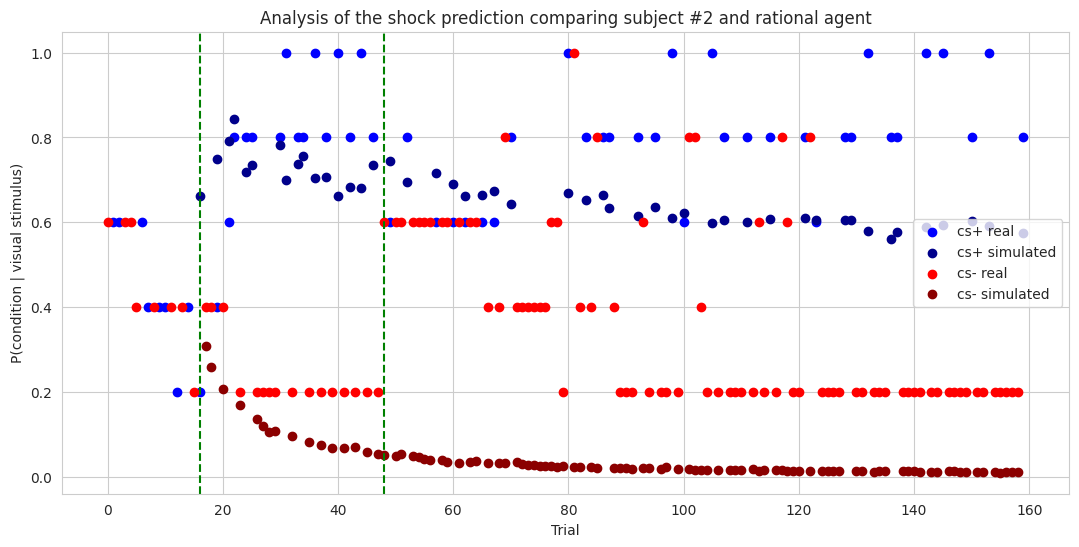

In [60]:
fig = plt.figure(figsize=(13,6))
plt.title('Analysis of the shock prediction comparing subject #2 and rational agent')
plt.scatter(x_plus_real, y_plus_real, color='blue', label='cs+ real')
plt.scatter(array_csplus_simulated[:,0], array_csplus_simulated[:,1], color='darkblue', label='cs+ simulated')
plt.scatter(x_minus_real, y_minus_real, color='red', label='cs- real')
plt.scatter(array_csminus_simulated[:,0], array_csminus_simulated[:,1], color='darkred', label='cs- simulated')
plt.legend(loc='right')
plt.axvline(x=16, linestyle='--', color='green')
plt.axvline(x=48, linestyle='--', color='green')
plt.xlabel('Trial')
plt.ylabel('P(condition | visual stimulus)')
plt.show()

# correlation

## analysis of the correlation between rational agent and real subject with pearson

In [61]:
# rating between 16-160 trial rational agent
rating_rational = total_array_simulated

In [143]:
df_correlation = pd.DataFrame(columns=['subject','pearson','r2score','person_disc','cohen_disc'])
path_sias = 'data/sias_score.csv'
path_lds = 'data/lds_subjects.csv'
len_sub = 6

top_lds_list = anxious_subjects(path_lds, len_sub, 'top')
bot_lds_list = anxious_subjects(path_lds, len_sub, 'bot')
top_sias_list = anxious_subjects(path_sias, len_sub, 'top')
bot_sias_list = anxious_subjects(path_sias, len_sub, 'bot')

more_lds = pd.DataFrame(columns=['Subject','ratings'])
less_lds = pd.DataFrame(columns=['Subject','ratings'])
more_sias = pd.DataFrame(columns=['Subject','ratings'])
less_sias = pd.DataFrame(columns=['Subject','ratings'])


for sub in valid_sub:
    subj_ = extract_correct_csv.read_correct_subject_csv(sub)
    df_sub = pd.read_csv('data/newLookAtMe/newLookAtMe'+subj_+'.csv')
    df_sub = df_sub[['shock', 'rating', 'morphing level']]
    df_sub['shock'] = df_sub['shock'].astype(int)
    df_sub['morphing level'] = [int(d == 6) for d in df_sub['morphing level']]
    df_sub['rating'] = df_sub['rating'].replace([1, 2, 3, 4, 5], [0.2, 0.4, 0.6, 0.8, 1])
    df_sub_learn = df_sub[16:]
    rating_sub = np.array(df_sub_learn['rating'])

    # remove nan
    bad = ~np.logical_or(np.isnan(rating_sub), np.isnan(rating_rational))
    rating_sub_ = np.compress(bad, rating_sub)
    rating_rational_ = np.compress(bad, rating_rational)

    lds = pd.DataFrame({'Subject':subj_,'ratings':[rating_sub]})

    if sub in top_lds_list:
        more_lds = pd.concat([more_lds,lds])
    if sub in bot_lds_list:
        less_lds = pd.concat([less_lds,lds])
    if sub in top_sias_list:
        more_sias = pd.concat([more_sias,lds])
    if sub in bot_sias_list:
        less_sias = pd.concat([less_sias,lds])

    #discretization of rating rational
    round_vector = np.array([0.2, 0.4, 0.6, 0.8, 1])
    rating_rational_discr = np.round(rating_rational_ / 0.2) * 0.2
    rating_rational_discr = np.clip(rating_rational_discr, round_vector.min(), round_vector.max())

    #pearson corr coeff
    pearson = round(np.corrcoef(rating_sub_,rating_rational_)[0][1],2)

    #r2 score
    r2 = round(r2_score(rating_sub_,rating_rational_),2)

    #pearson discr
    pearson_disc = round(np.corrcoef(rating_sub_,rating_rational_discr)[0][1],2)

    #cohen kappa discr
    cohen_disc = round(cohen_kappa_score(rating_sub_*10,rating_rational_discr*10),2)

    # write line
    df_tmp = pd.DataFrame({'subject':sub,'pearson':pearson,'r2score':r2,'person_disc':pearson_disc,'cohen_disc':cohen_disc},index=np.arange(1))
    df_correlation = pd.concat([df_correlation,df_tmp])


sias_df = pd.read_csv('data/sias_score.csv').drop(columns='social_anxiety')
sias_df['subject'] = [float(x) for x in sias_df['subject']]

lds_df = pd.read_csv('data/lds_subjects.csv')
lds_df['subject'] = [float(x) for x in lds_df['subject']]

df_correlation['subject'] = [float(x) for x in df_correlation['subject']]

df_corr_ = pd.concat([sias_df.set_index('subject'), lds_df.set_index('subject'), df_correlation.set_index('subject')], axis=1).reset_index()

# drop nan
lds_df['subject'] = [float(x) for x in lds_df['subject']]

In [178]:
more_lds.sort_values(by='Subject')
less_lds.sort_values(by='Subject')
more_sias.sort_values(by='Subject')
less_sias.sort_values(by='Subject')

rat_more_lds = []
for row in more_lds.iterrows():
    rat_more_lds.append(list(row[1][1]))

rat_less_lds = []
for row in less_lds.iterrows():
    rat_less_lds.append(list(row[1][1]))

rat_more_sias = []
for row in more_sias.iterrows():
    rat_more_sias.append(list(row[1][1]))

rat_less_sias = []
for row in less_sias.iterrows():
    rat_less_sias.append(list(row[1][1]))

rat_more_lds = np.array(rat_more_lds).flatten()
rat_less_lds = np.array(rat_less_lds).flatten()
rat_more_sias = np.array(rat_more_sias).flatten()
rat_less_sias = np.array(rat_less_sias).flatten()


In [182]:
duplicated_rating_sub = [item for _ in range(len_sub) for item in rating_sub]


lds = pd.DataFrame(data=list(zip(rat_more_lds,duplicated_rating_sub,rat_less_lds)),columns=['more_lds','rational','low_lds'])
sias = pd.DataFrame(data=list(zip(rat_more_sias,duplicated_rating_sub,rat_less_sias)),columns=['more_sias','rational','low_sias'])

lds = lds.dropna()
sias = sias.dropna()

## autorank lds using all votes

In [183]:
result = autorank(lds, alpha=0.05, verbose=False, approach='bayesian')
print(result)

RankResult(rankdf=
          median  mad ci_lower ci_upper effect_size   magnitude  p_equal  \
low_lds      0.6  0.2      0.4      0.6         0.0  negligible      NaN   
rational     0.4  0.2      0.4      0.4    0.674491      medium      0.0   
more_lds     0.2  0.0      0.2      0.4    1.907748       large      0.0   

          p_smaller decision  
low_lds         NaN       NA  
rational    0.99786  smaller  
more_lds    1.00000  smaller  
pvalue=None
cd=None
omnibus=bayes
posthoc=bayes
all_normal=False
pvals_shapiro=[3.12706810479663e-22, 9.982337700117206e-33, 4.4250038427640525e-34]
homoscedastic=None
pval_homogeneity=None
homogeneity_test=None
alpha=0.05
alpha_normality=0.016666666666666666
num_samples=796
posterior_matrix=
         low_lds                 rational                 more_lds
low_lds      NaN  (0.99786, 0.0, 0.00214)          (1.0, 0.0, 0.0)
rational     NaN                      NaN  (0.99896, 0.00104, 0.0)
more_lds     NaN                      NaN                

In [184]:
result = autorank(sias, alpha=0.05, verbose=False, approach='bayesian')
print(result)

RankResult(rankdf=
           median  mad ci_lower ci_upper effect_size   magnitude  p_equal  \
more_sias     0.4  0.2      0.4      0.6         0.0  negligible      NaN   
rational      0.4  0.2      0.4      0.4         0.0  negligible      0.0   
low_sias      0.4  0.2      0.2      0.4         0.0  negligible      0.0   

           p_smaller decision  
more_sias        NaN       NA  
rational     0.00122   larger  
low_sias     0.99830  smaller  
pvalue=None
cd=None
omnibus=bayes
posthoc=bayes
all_normal=False
pvals_shapiro=[2.5688598636411213e-27, 1.3126846802020243e-32, 4.389839924755982e-31]
homoscedastic=None
pval_homogeneity=None
homogeneity_test=None
alpha=0.05
alpha_normality=0.016666666666666666
num_samples=786
posterior_matrix=
          more_sias                 rational               low_sias
more_sias       NaN  (0.00122, 0.0, 0.99878)  (0.9983, 0.0, 0.0017)
rational        NaN                      NaN        (1.0, 0.0, 0.0)
low_sias        NaN                      NaN

In [177]:
merged_df = pd.concat([sias_df.set_index('subject'), lds_df.set_index('subject'), df_correlation.set_index('subject')], axis=1)
merged_df = merged_df.reset_index()
merged_df

,subject,sias_score,lds,pearson,r2score,person_disc,cohen_disc
0,1.0,21.0,0.201,0.23,-4.97,0.18,-0.02
1,2.0,11.0,0.828,0.75,-0.75,0.68,0.17
2,3.0,30.0,0.504,NaN,NaN,NaN,NaN
3,4.0,12.0,0.111,0.41,-1.86,0.35,0.05
4,5.0,30.0,0.953,0.71,-0.63,0.62,0.14
5,6.0,8.0,1.312,0.73,-0.08,0.65,0.24
6,7.0,25.0,0.535,0.67,-1.23,0.60,0.07
7,8.0,6.0,0.583,NaN,NaN,NaN,NaN
8,9.0,NaN,NaN,NaN,NaN,NaN,NaN
9,10.0,10.0,0.682,NaN,NaN,NaN,NaN


In [64]:
df_corr_notna = merged_df[merged_df['pearson'].notna()]
df_corr_notna = df_corr_notna[merged_df['lds'].notna()]
df_corr_notna = df_corr_notna[merged_df['sias_score'].notna()]
df_corr_notna

/tmp/ipykernel_50788/3410993754.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_corr_notna = df_corr_notna[merged_df['lds'].notna()]
/tmp/ipykernel_50788/3410993754.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_corr_notna = df_corr_notna[merged_df['sias_score'].notna()]


,subject,sias_score,lds,pearson,r2score,person_disc,cohen_disc
0,1.0,21.0,0.201,0.31,-4.44,0.31,0.04
1,2.0,11.0,0.828,0.71,-0.39,0.70,0.25
3,4.0,12.0,0.111,0.41,-1.49,0.40,0.05
4,5.0,30.0,0.953,0.70,-0.26,0.68,0.25
5,6.0,8.0,1.312,0.72,0.18,0.72,0.28
6,7.0,25.0,0.535,0.69,-0.73,0.70,0.22
12,13.0,16.0,0.141,0.39,-3.38,0.38,0.04
14,15.0,16.0,0.693,0.63,-0.12,0.64,0.29
15,16.0,55.0,0.621,0.36,-1.30,0.34,0.07
16,17.0,16.0,-0.382,0.25,-2.57,0.26,0.09


In [65]:
#extract subject with high value lds and lower lds
lds_ = df_corr_notna.sort_values('lds').reset_index(drop=True)
lower_lds = lds_[:7]
higher_lds = lds_[-7:]

# Analysis

In [66]:
sias_ = df_corr_notna.sort_values('sias_score',ascending=True).reset_index().drop(columns='index')
lower_sias = sias_[:5]
sias_ = df_corr_notna.sort_values('sias_score',ascending=False).reset_index().drop(columns='index')
higher_sias= sias_[:5]

## Analysis subject more fear gen vs less fear gen

In [67]:
l_low_p = lower_lds['pearson'].median()
l_hig_p = higher_lds['pearson'].median()
l_low_r = lower_lds['r2score'].median()
l_hig_r = higher_lds['r2score'].median()

print('Correlation between 7 more/less fear gen subjects with the rational agent\n')
print('Pearson\nHigh fear gen: ',l_low_p, ' Low fear gen:',l_hig_p)
print('\nR2score\nHigh fear gen: ',l_low_r, ' Low fear gen:',l_hig_r)

Correlation between 7 more/less fear gen subjects with the rational agent

Pearson
High fear gen:  0.31  Low fear gen: 0.79

R2score
High fear gen:  -2.57  Low fear gen: 0.1


## Analysis subject more anxiety vs less anxiety

In [68]:
lower_sias

,subject,sias_score,lds,pearson,r2score,person_disc,cohen_disc
0,26.0,3.0,0.834,0.66,-0.07,0.66,0.23
1,51.0,6.0,0.641,0.68,-0.22,0.67,0.35
2,6.0,8.0,1.312,0.72,0.18,0.72,0.28
3,2.0,11.0,0.828,0.71,-0.39,0.70,0.25
4,4.0,12.0,0.111,0.41,-1.49,0.40,0.05


In [69]:
s_low_p = lower_sias['pearson'].median()
s_hig_p = higher_sias['pearson'].median()

s_low_r = lower_sias['r2score'].median()
s_hig_r = higher_sias['r2score'].median()

print('Correlation between 5 more/less anxiety subjects with the rational agent\n')
print('Pearson\nHigh anxiety: ',s_hig_p, ' Low anxiety:',s_low_p)
print('\nR2score\nHigh anxiety: ',s_hig_r, ' Low anxiety:',s_low_r)

Correlation between 5 more/less anxiety subjects with the rational agent

Pearson
High anxiety:  0.4  Low anxiety: 0.68

R2score
High anxiety:  -1.3  Low anxiety: -0.22


In [70]:
sias_

,subject,sias_score,lds,pearson,r2score,person_disc,cohen_disc
0,16.0,55.0,0.621,0.36,-1.30,0.34,0.07
1,23.0,37.0,0.279,0.40,-1.56,0.40,0.17
2,46.0,31.0,0.006,0.02,-2.83,0.01,0.01
3,27.0,31.0,1.328,0.91,0.50,0.88,0.45
4,5.0,30.0,0.953,0.70,-0.26,0.68,0.25
5,7.0,25.0,0.535,0.69,-0.73,0.70,0.22
6,43.0,25.0,1.043,0.79,-0.03,0.78,0.25
7,48.0,24.0,0.365,0.53,-0.98,0.53,0.13
8,50.0,23.0,0.443,0.21,-2.47,0.19,0.09
9,33.0,22.0,0.969,0.68,-0.13,0.68,0.30


In [71]:
lower_sias['pearson'].median()

0.68

In [72]:
higher_sias['pearson'].median()

0.4

# autorank

## SIAS: low vs high. pearson corr coeff

In [74]:
total_array_simulated = np.load('output/pyro/complete_rational/total.npy', allow_pickle=True)
values = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
discretized_data = np.digitize(total_array_simulated, values)

In [75]:
sias_autorank = pd.DataFrame(columns=('pearson low','pearson high'))
sias_autorank['pearson low'] = lower_sias['pearson']
sias_autorank['pearson high'] = higher_sias['pearson']

result = autorank(sias_autorank, alpha=0.05, verbose=False, approach='bayesian')
print(result)

RankResult(rankdf=
              median   mad ci_lower ci_upper effect_size   magnitude  p_equal  \
pearson low     0.68  0.03     0.41     0.72         0.0  negligible      NaN   
pearson high    0.40   0.3     0.02     0.91    0.885864       large  0.01256   

              p_smaller      decision  
pearson low         NaN            NA  
pearson high    0.83934  inconclusive  
pvalue=None
cd=None
omnibus=bayes
posthoc=bayes
all_normal=False
pvals_shapiro=[0.015134504064917564, 0.9022369384765625]
homoscedastic=None
pval_homogeneity=None
homogeneity_test=None
alpha=0.05
alpha_normality=0.025
num_samples=5
posterior_matrix=
             pearson low                pearson high
pearson low          NaN  (0.83934, 0.01256, 0.1481)
pearson high         NaN                         NaN
decision_matrix=
               pearson low  pearson high
pearson low            NaN  inconclusive
pearson high  inconclusive           NaN
rope=0.1
rope_mode=effsize
effect_size=akinshin_gamma)


In [76]:
result[0]

,median,mad,ci_lower,ci_upper,effect_size,magnitude,p_equal,p_smaller,decision
pearson low,0.68,0.03,0.41,0.72,0.0,negligible,NaN,NaN,NA
pearson high,0.40,0.3,0.02,0.91,0.885864,large,0.01256,0.83934,inconclusive


## SIAS: low vs high. r2 score

In [77]:
sias_autorank = pd.DataFrame(columns=('r2 low','r2 high'))
sias_autorank['r2 low'] = lower_sias['r2score']
sias_autorank['r2 high'] = higher_sias['r2score']

result = autorank(sias_autorank, alpha=0.05, verbose=False, approach='bayesian')
print(result)

RankResult(rankdf=
          mean       std  ci_lower  ci_upper effect_size   magnitude  p_equal  \
r2 low  -0.398  0.645345  -1.64324   0.84724         0.0  negligible      NaN   
r2 high -1.090  1.275696 -3.551548  1.371548    0.684533      medium  0.01326   

         p_smaller      decision  
r2 low         NaN            NA  
r2 high    0.84014  inconclusive  
pvalue=None
cd=None
omnibus=bayes
posthoc=bayes
all_normal=True
pvals_shapiro=[0.18232591450214386, 0.9398150444030762]
homoscedastic=None
pval_homogeneity=None
homogeneity_test=None
alpha=0.05
alpha_normality=0.025
num_samples=5
posterior_matrix=
        r2 low                     r2 high
r2 low     NaN  (0.84014, 0.01326, 0.1466)
r2 high    NaN                         NaN
decision_matrix=
               r2 low       r2 high
r2 low            NaN  inconclusive
r2 high  inconclusive           NaN
rope=0.1
rope_mode=effsize
effect_size=cohen_d)


In [78]:
result[0]

,mean,std,ci_lower,ci_upper,effect_size,magnitude,p_equal,p_smaller,decision
r2 low,-0.398,0.645345,-1.64324,0.84724,0.0,negligible,NaN,NaN,NA
r2 high,-1.090,1.275696,-3.551548,1.371548,0.684533,medium,0.01326,0.84014,inconclusive


## LDS: low vs high. pearson corr coef

In [79]:
lds_autorank = pd.DataFrame(columns=('pearson low','pearson high'))
lds_autorank['pearson low'] = lower_lds['pearson']
lds_autorank['pearson high'] = higher_lds['pearson']

result = autorank(lds_autorank, alpha=0.05, verbose=False, approach='bayesian')
print(result)

RankResult(rankdf=
                  mean       std  ci_lower  ci_upper effect_size   magnitude  \
pearson low   0.277143  0.145569  0.083405  0.470881         0.0  negligible   
pearson high       NaN       NaN       NaN       NaN         NaN       large   

              p_equal  p_smaller decision  
pearson low       NaN        NaN       NA  
pearson high      0.0        1.0  smaller  
pvalue=None
cd=None
omnibus=bayes
posthoc=bayes
all_normal=True
pvals_shapiro=[0.25091370940208435, 1.0]
homoscedastic=None
pval_homogeneity=None
homogeneity_test=None
alpha=0.05
alpha_normality=0.025
num_samples=7
posterior_matrix=
             pearson low     pearson high
pearson low          NaN  (1.0, 0.0, 0.0)
pearson high         NaN              NaN
decision_matrix=
             pearson low pearson high
pearson low          NaN      smaller
pearson high      larger          NaN
rope=0.1
rope_mode=effsize
effect_size=cohen_d)


In [80]:
result[0]

,mean,std,ci_lower,ci_upper,effect_size,magnitude,p_equal,p_smaller,decision
pearson low,0.277143,0.145569,0.083405,0.470881,0.0,negligible,NaN,NaN,NA
pearson high,NaN,NaN,NaN,NaN,NaN,large,0.0,1.0,smaller


## LDS: low vs high. r2 corr coef

In [81]:
lds_autorank = pd.DataFrame(columns=('r2score low','r2score high'))
lds_autorank['r2score low'] = lower_lds['r2score']
lds_autorank['r2score high'] = higher_lds['r2score']

result = autorank(lds_autorank, alpha=0.05, verbose=False, approach='bayesian')
print(result)

RankResult(rankdf=
                  mean       std  ci_lower  ci_upper effect_size   magnitude  \
r2score low  -2.564286  1.095367 -4.022106 -1.106465         0.0  negligible   
r2score high       NaN       NaN       NaN       NaN         NaN       large   

              p_equal  p_smaller decision  
r2score low       NaN        NaN       NA  
r2score high      0.0        1.0  smaller  
pvalue=None
cd=None
omnibus=bayes
posthoc=bayes
all_normal=True
pvals_shapiro=[0.36002030968666077, 1.0]
homoscedastic=None
pval_homogeneity=None
homogeneity_test=None
alpha=0.05
alpha_normality=0.025
num_samples=7
posterior_matrix=
             r2score low     r2score high
r2score low          NaN  (1.0, 0.0, 0.0)
r2score high         NaN              NaN
decision_matrix=
             r2score low r2score high
r2score low          NaN      smaller
r2score high      larger          NaN
rope=0.1
rope_mode=effsize
effect_size=cohen_d)


In [82]:
result[0]

,mean,std,ci_lower,ci_upper,effect_size,magnitude,p_equal,p_smaller,decision
r2score low,-2.564286,1.095367,-4.022106,-1.106465,0.0,negligible,NaN,NaN,NA
r2score high,NaN,NaN,NaN,NaN,NaN,large,0.0,1.0,smaller


In [83]:
std = 0.3
means = [0.2, 0.3, 0.5, 0.8, 0.85, 0.9]
sample_size = 50
data = pd.DataFrame()
for i, mean in enumerate(means):
    data['pop_%i' % i] = np.random.normal(mean, std, sample_size).clip(0, 1)
data

,pop_0,pop_1,pop_2,pop_3,pop_4,pop_5
0,0.255378,0.948095,0.383810,0.986213,0.429947,0.735235
1,0.554327,0.442666,0.435739,0.536383,0.479074,1.000000
2,0.331347,0.351250,0.517586,0.861229,0.488186,0.493809
3,0.206977,0.827599,0.482343,1.000000,0.765548,1.000000
4,0.020159,0.000000,0.000000,1.000000,0.924240,1.000000
5,0.215870,0.000000,0.028142,1.000000,0.945561,1.000000
6,0.000000,0.000000,0.856143,1.000000,1.000000,0.428462
7,0.000000,0.168136,0.995804,1.000000,0.302470,1.000000
8,0.132950,0.081152,1.000000,0.962952,0.591234,0.902816
9,0.396505,0.603933,0.510660,1.000000,1.000000,0.807450


# Analysis sliding window K

In [84]:
k_wind = [2, 5, 10, 25, 50, 100, 150]
for k in list(k_wind):

    array_csplus_simulated = np.load('output/pyro/sliding_wind/k'+str(k)+'_csplus.npy',allow_pickle=True)
    array_csminus_simulated = np.load('output/pyro/sliding_wind/k'+str(k)+'_csminus.npy',allow_pickle=True)
    total_array_simulated = np.load('output/pyro/sliding_wind/k'+str(k)+'_total.npy',allow_pickle=True)

    rating_rational = total_array_simulated
    rating_rational = rating_rational[16:]

    df_correlation = pd.DataFrame(columns=['subject','pearson'])

    for sub in valid_sub:
        subj_ = extract_correct_csv.read_correct_subject_csv(sub)
        df_sub = pd.read_csv('data/newLookAtMe/newLookAtMe'+subj_+'.csv')
        df_sub = df_sub[['shock', 'rating', 'morphing level']]
        df_sub['shock'] = df_sub['shock'].astype(int)
        df_sub['morphing level'] = [int(d == 6) for d in df_sub['morphing level']]
        df_sub['rating'] = df_sub['rating'].replace([1, 2, 3, 4, 5], [0.2, 0.4, 0.6, 0.8, 1])
        df_sub_learn = df_sub[16:]
        rating_sub = np.array(df_sub_learn['rating'])

        #remove nan
        bad = ~np.logical_or(np.isnan(rating_sub), np.isnan(rating_rational))
        rating_sub_ = np.compress(bad, rating_sub)
        rating_rational_ = np.compress(bad, rating_rational)

        pearson = round(np.corrcoef(rating_sub_,rating_rational_)[0][1],2)
        df_correlation = df_correlation.append({'subject':sub,'pearson':pearson},ignore_index=True)
    sias_df = pd.read_csv('data/sias_score.csv').drop(columns='social_anxiety')
    sias_df['subject'] = [float(x) for x in sias_df['subject']]

    lds_df = pd.read_csv('data/lds_subjects.csv')

    lds_df['subject'] = [float(x) for x in lds_df['subject']]
    df_corr = df_correlation.join(lds_df, lsuffix='', rsuffix='_other',how='inner').drop(columns='subject_other')
    df_corr_ = df_corr.join(sias_df,lsuffix='', rsuffix='_other',how='inner').drop(columns='subject_other')
    df_corr_notna = df_corr_[df_corr_['pearson'].notna()]
    df_corr_notna = df_corr_notna[df_corr_['lds'].notna()]
    df_corr_notna = df_corr_notna[df_corr_['sias_score'].notna()]
    lds_ = df_corr_notna.sort_values('lds').reset_index().drop(columns='index')
    lower_lds = lds_[:7]
    higher_lds = lds_[-7:]

    print('\n\n--------------- K = '+str(k)+' ---------------')

    print('7 subj less lds corr with rational agent:',lower_lds['pearson'].median())
    print('7 subj more lds corr with rational agent:',higher_lds['pearson'].median())

    sias_ = df_corr_notna.sort_values('sias_score',ascending=True).reset_index().drop(columns='index')
    lower_sias = sias_[:7]
    sias_ = df_corr_notna.sort_values('sias_score',ascending=False).reset_index().drop(columns='index')
    higher_sias= sias_[:7]
    print()
    print('7 subj less sias corr with rational agent:',lower_sias['pearson'].median())
    print('7 subj more sias corr with rational agent:',higher_sias['pearson'].median())



--------------- K = 2 ---------------
7 subj less lds corr with rational agent: 0.32
7 subj more lds corr with rational agent: 0.48

7 subj less sias corr with rational agent: 0.48
7 subj more sias corr with rational agent: 0.35


--------------- K = 5 ---------------
7 subj less lds corr with rational agent: 0.39
7 subj more lds corr with rational agent: 0.57

7 subj less sias corr with rational agent: 0.57
7 subj more sias corr with rational agent: 0.4


--------------- K = 10 ---------------
7 subj less lds corr with rational agent: 0.45
7 subj more lds corr with rational agent: 0.63

7 subj less sias corr with rational agent: 0.63
7 subj more sias corr with rational agent: 0.43


--------------- K = 25 ---------------
7 subj less lds corr with rational agent: 0.48
7 subj more lds corr with rational agent: 0.69

7 subj less sias corr with rational agent: 0.66
7 subj more sias corr with rational agent: 0.41


--------------- K = 50 ---------------
7 subj less lds corr with rational

In [85]:
df_corr_notna['sias_score'] = [round(x,2) for x in preprocessing.normalize([df_corr_notna['sias_score']])[0]]
df_corr_notna['lds'] = [round(x,2) for x in preprocessing.normalize([df_corr_notna['lds']])[0]]
df_corr_notna['pearson'] = [round(x,2) for x in preprocessing.normalize([df_corr_notna['pearson']])[0]]


In [86]:
df_corr_notna['subject'] = [int(x) for x in df_corr_notna['subject']]

In [87]:
lds_ = df_corr_notna.sort_values('lds').reset_index().drop(columns='index')
lower_lds = lds_[:5]
higher_lds = lds_[-5:]

In [88]:
subjects = tuple(df_corr_notna['subject'])

In [89]:
values = {'pearson':(),'lds':(),'sias':()}
for index,row in df_corr_notna.iterrows():
    new_p = values['pearson'] + (row['pearson'],)
    values.update({'pearson':new_p})
    new_l = values['lds'] + (row['lds'],)
    values.update({'lds':new_l})
    new_s = values['sias'] + (row['sias_score'],)
    values.update({'sias':new_s})

In [90]:
values_no_sias = {'pearson':(),'lds':()}
for index,row in df_corr_notna.iterrows():
    new_p = values_no_sias['pearson'] + (row['pearson'],)
    values_no_sias.update({'pearson':new_p})
    new_l = values_no_sias['lds'] + (row['lds'],)
    values_no_sias.update({'lds':new_l})

In [91]:
subjects = tuple(df_corr_notna['subject'])
values_no_lds = {'pearson': (), 'sias': ()}
for index, row in df_corr_notna.iterrows():
    new_p = values_no_lds['pearson'] + (row['pearson'],)
    values_no_lds.update({'pearson': new_p})
    new_s = values_no_lds['sias'] + (row['sias_score'],)
    values_no_lds.update({'sias': new_s})

## plot correlation

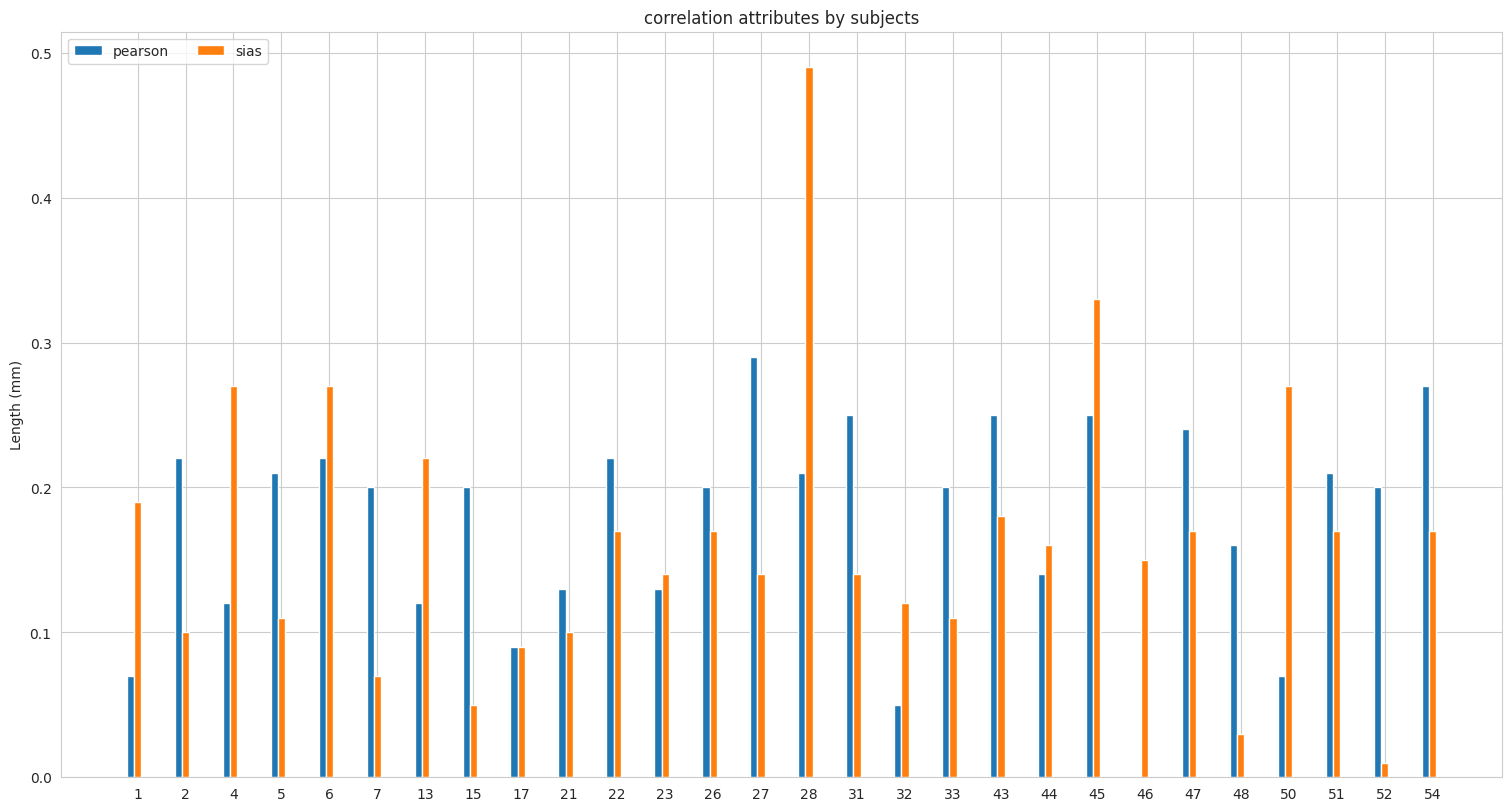

In [92]:
x = np.arange(len(subjects))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(15,8),constrained_layout=True)

for attribute, measurement in values_no_lds.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('correlation attributes by subjects')
ax.set_xticks(x + width, subjects)
ax.legend(loc='upper left', ncols=3)

plt.show()

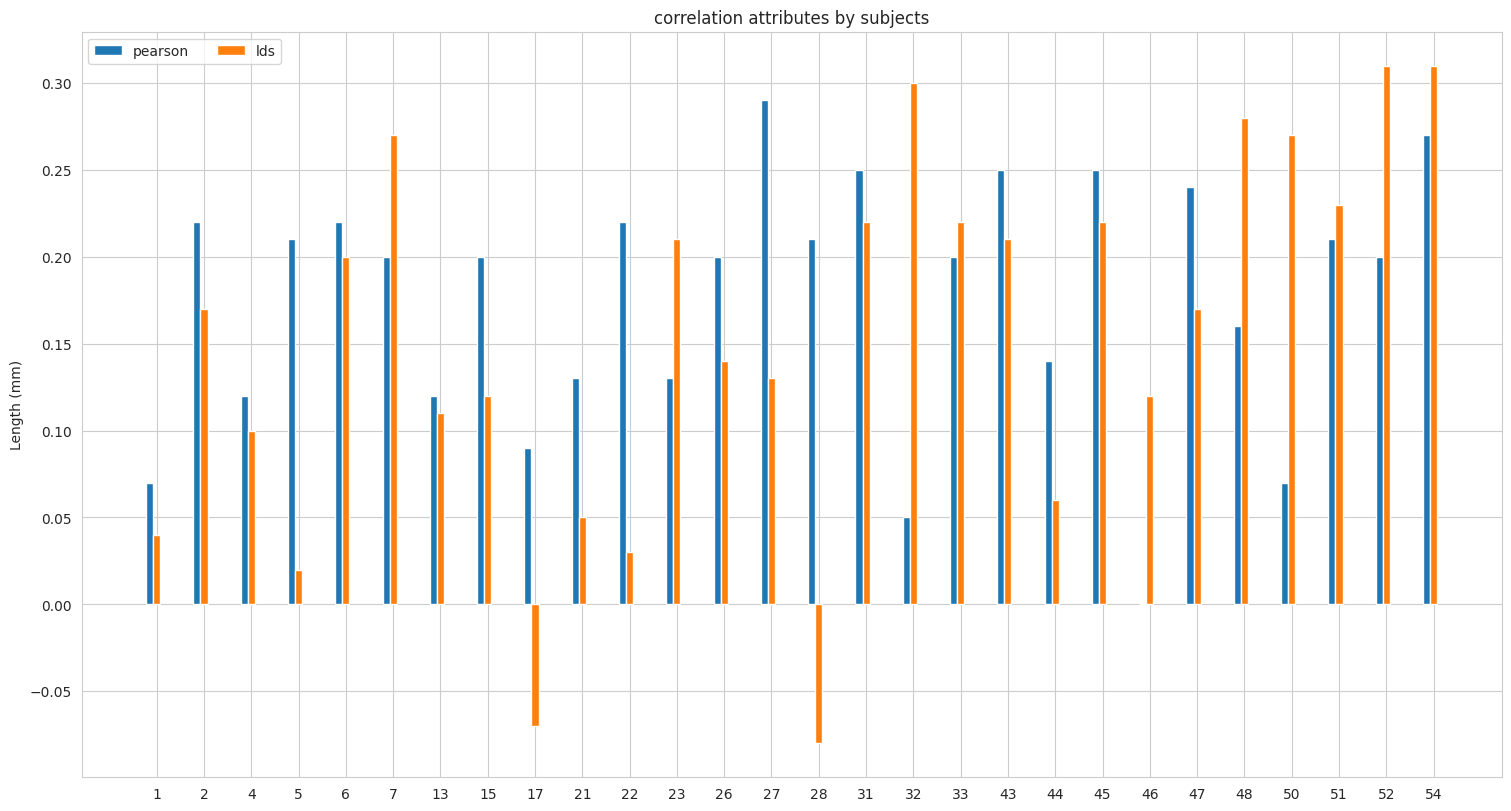

In [93]:
x = np.arange(len(subjects))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(15,8),constrained_layout=True)

for attribute, measurement in values_no_sias.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('correlation attributes by subjects')
ax.set_xticks(x + width, subjects)
ax.legend(loc='upper left', ncols=3)

plt.show()

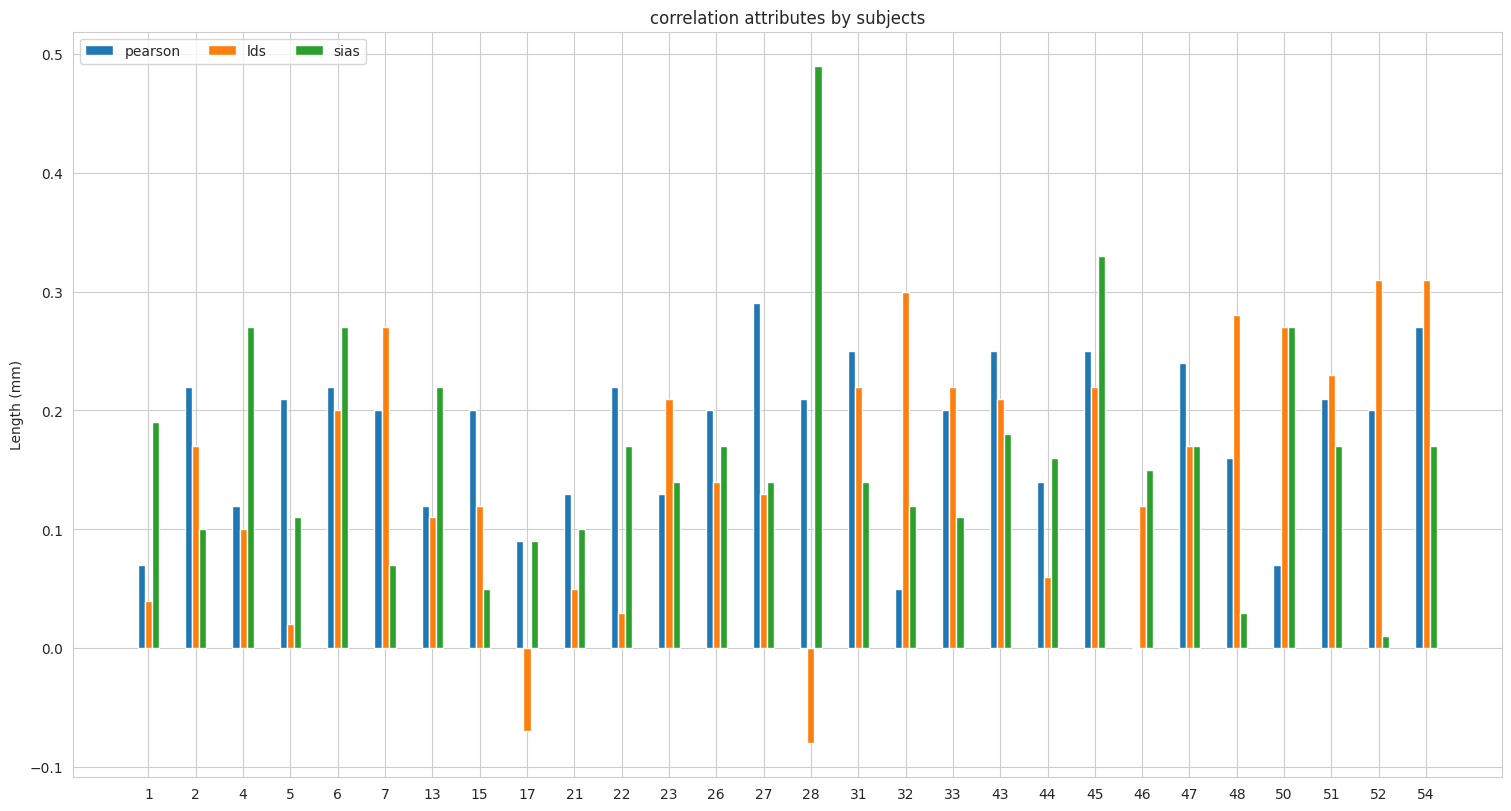

In [94]:
x = np.arange(len(subjects))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(15,8),constrained_layout=True)

for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('correlation attributes by subjects')
ax.set_xticks(x + width, subjects)
ax.legend(loc='upper left', ncols=3)

plt.show()

# rational agent sliding window

The idea is to have a rational agent with a limited memory over previous trials.
k = param sliding window dimension


In [95]:
import extract_correct_csv
valid_sub = extract_correct_csv.extract_only_valid_subject()

In [96]:
# read dataset
df = pd.read_csv('data/newLookAtMe/newLookAtMe02.csv')
df_rational = df[['morphing level', 'shock']]
df_rational['shock'] = df_rational['shock'].astype(int) #setting shock as int instead of boolean
df_rational['morphing level'] = [int(d==6) for d in df_rational['morphing level']] # if morphing level==6 -> 1

/tmp/ipykernel_50788/522845498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rational['shock'] = df_rational['shock'].astype(int) #setting shock as int instead of boolean
/tmp/ipykernel_50788/522845498.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rational['morphing level'] = [int(d==6) for d in df_rational['morphing level']] # if morphing level==6 -> 1


In [97]:
data_np = df_rational.to_numpy()


def counter_window(data, k=0):
    N = data.shape[0]
    counter = torch.zeros((N,4))
    for i in range(len(data)):
        dict_ = {'[0 0]':0, '[0 1]': 0, '[1 0]':0, '[1 1]':0}
        if k == 0 or k > i:
            tmp_data = data[:i+1]
        else:
            tmp_data = data[i-k:i+1]
            #print('im here')
        # count occurencies
        for x in tmp_data:
            dict_[str(x)] += 1
        values = np.array(list(dict_.values()))
        counter[i] = torch.tensor(values)
    return counter

In [98]:
counter = counter_window(data_np, 3)

counter = counter.reshape((len(data_np), 2, 2))
counter.shape

torch.Size([160, 2, 2])

In [99]:
# categorical/multinomial distribution

# uniform prior
prior_counts = torch.ones((2,2))


#model
def model(data):
    prior = pyro.sample("prior", dist.Dirichlet(prior_counts))
    total_counts = int(data.sum())
    pyro.sample("likelihood", dist.Multinomial(total_counts, prior), obs=data)


nuts_kernel = NUTS(model)
num_samples, warmup_steps = (300, 200)

mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps, disable_progbar=True)
all_means = []

# sampling
for i in range(len(counter)):
    mcmc.run(counter[i])
    hmc_samples = {k: v.detach().cpu().numpy()
                   for k, v in mcmc.get_samples().items()}
    means = hmc_samples['prior'].mean(axis=0)
    stds = hmc_samples['prior'].std(axis=0)
    print('observation: ', data_np[i])
    print('probabilities: ', means)
    all_means.append(means)

observation:  [0 0]
probabilities:  [[0.66521674 0.33478332]
 [0.5207079  0.479292  ]]
observation:  [1 0]
probabilities:  [[0.6648052  0.3351953 ]
 [0.6830721  0.31692827]]
observation:  [1 0]
probabilities:  [[0.6596339  0.34036613]
 [0.7509285  0.2490714 ]]
observation:  [0 0]
probabilities:  [[0.7478743  0.25212547]
 [0.75527453 0.24472575]]
observation:  [0 0]
probabilities:  [[0.72868466 0.27131525]
 [0.733763   0.26623723]]
observation:  [0 0]
probabilities:  [[0.809086   0.19091399]
 [0.6685929  0.33140707]]
observation:  [1 0]
probabilities:  [[0.8094855  0.19051462]
 [0.6802061  0.31979364]]
observation:  [1 0]
probabilities:  [[0.7442438  0.25575662]
 [0.755265   0.24473506]]
observation:  [0 0]
probabilities:  [[0.7512825  0.24871726]
 [0.7388446  0.26115534]]
observation:  [1 0]
probabilities:  [[0.6697252  0.33027518]
 [0.80444425 0.19555607]]
observation:  [1 0]
probabilities:  [[0.68783563 0.31216404]
 [0.8117855  0.1882146 ]]
observation:  [0 0]
probabilities:  [[0.735

KeyboardInterrupt: 

## Rational agent discretisation

In [ ]:
valid_subjects = extract_correct_csv.extract_only_valid_subject()
len(valid_subjects)

In [ ]:
total_array_simulated = np.load('output/pyro/complete_rational/total.npy',allow_pickle=True)
total_array_simulated

In [ ]:
values = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
discretized_data = np.digitize(total_array_simulated, values)
print(discretized_data.shape)


df_global = pd.DataFrame(columns=['Subject', 'Rating rational', 'Rating real'])

for sub in valid_subjects:
    string_sub = extract_correct_csv.read_correct_subject_csv(sub)
    df_sub = pd.read_csv('data/newLookAtMe/newLookAtMe'+string_sub+'.csv')
    df_sub = df_sub[16:]
    tmp_df = pd.DataFrame({'Subject': sub, 'Rating rational': discretized_data, 'Rating real': df_sub['rating']})
    df_global = pd.concat([df_global, tmp_df])

df_global = df_global.reset_index(drop=True)

In [ ]:
# useless up to now
'''df_global = df_global.groupby('Subject', as_index=False).agg({'Rating rational': lambda x: x.tolist(), 'Rating real': lambda x: x.tolist()})
df_global['Rating rational'] = df_global['Rating rational'].apply(lambda x: np.array(x))
df_global['Rating real'] = df_global['Rating real'].apply(lambda x: np.array(x))'''

In [ ]:
valid_subjects = df_global.Subject.unique()
valid_subjects

In [ ]:
dict_results = {}
for x in valid_subjects:
    df_sub_ = df_global[df_global.Subject == x].dropna().drop(columns=['Subject']).reset_index(drop=True)
    df_sub_['Rating rational'] = df_sub_['Rating rational'].astype(float)
    result = intraclass_correlation(df_sub_).value
    dict_results[x] = result

dict_results


In [ ]:
df_icc = pd.DataFrame(list(dict_results.items()), columns=['Subject', 'ICC'])
df_icc

In [ ]:
path_sias = 'data/sias_score.csv'
path_lds = 'data/lds_subjects.csv'

len_sub = 6
top_lds = anxious_subjects(path_lds, len_sub, 'top')
bot_lds = anxious_subjects(path_lds, len_sub, 'bot')

top_sias = anxious_subjects(path_sias, len_sub)
bot_sias = anxious_subjects(path_sias, len_sub, 'bot')

In [ ]:
mean_top_sias = df_icc[df_icc.Subject.isin(top_sias)]['ICC'].mean()
mean_bot_sias = df_icc[df_icc.Subject.isin(bot_sias)]['ICC'].mean()
mean_top_lds = df_icc[df_icc.Subject.isin(top_lds)]['ICC'].mean()
mean_bot_lds = df_icc[df_icc.Subject.isin(bot_lds)]['ICC'].mean()

In [ ]:
print(f'Average of the first {len_sub} subjects with higher sias score: {round(mean_top_sias, 2)}')
print(f'Average of the first {len_sub} subjects with lower sias score: {round(mean_bot_sias, 2)}')
print(f'Average of the first {len_sub} subjects with higher linear deviation score: {round(mean_top_lds,2)}')
print(f'Average of the first {len_sub} subjects with lower linear deviation score: {round(mean_bot_lds, 2)}')